In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

import random, re

import tensorflow as tf
from itertools import islice

#!pip install textpreprocess
from textpreprocess import *

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

from keras_preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional, GlobalMaxPool1D
from keras.constraints import max_norm, unit_norm
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [2]:
os.chdir('D:/Nikhila/PGP - AIML/2. Projects/9. Natural Language Processing/Project 2')

# Part A

• **DOMAIN**: Digital content and entertainment industry


• **CONTEXT**: The objective of this project is to build a text classification model that analyses the customer's sentiments based on their reviews in the IMDB database. The model uses a complex deep learning model to build an embedding layer followed by a classification algorithm to analyse the sentiment of the customers.


• **DATA DESCRIPTION**: The Dataset of 50,000 movie reviews from IMDB, labelled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocabulary size of 10,000. As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


• **PROJECT OBJECTIVE**: To Build a sequential NLP classifier which can use input text parameters to determine the
customer sentiments.


**Steps and tasks**:

#### 1. Import and analyse the data set.

#### 3. Perform following data analysis:

##### • Print shape of features and labels

In [3]:
vocab_size = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')


print('---'*20, f'\nNumber of rows in validation dataset: {x_valid.shape[0]}')
print(f'Number of columns in validation dataset: {x_valid.shape[1]}')
print(f'Number of unique words in validation dataset: {len(np.unique(np.hstack(x_valid)))}')


print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')


print('---'*20, f'\nUnique Categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')

------------------------------------------------------------ 
Number of rows in training dataset: 32000
Number of columns in training dataset: 20
Number of unique words in training dataset: 9659
------------------------------------------------------------ 
Number of rows in validation dataset: 8000
Number of columns in validation dataset: 20
Number of unique words in validation dataset: 7679
------------------------------------------------------------ 
Number of rows in test dataset: 10000
Number of columns in test dataset: 20
Number of unique words in test dataset: 8022
------------------------------------------------------------ 
Unique Categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


##### • Print value of any one feature and it's label

#### 4. Decode the feature value to get original sentence

**NOTE**- 1: 'Positive', 0: 'Negative'

In [4]:
def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

w2i, i2w = decode_review(x_train[15], y_train[15])

# get first 50 key, value pairs from id to word dictionary
print('---'*30, '\n', list(islice(i2w.items(), 0, 50)))

Review: of the best tv films ever aired <UNK> to the producers and writers of such a great piece of work
Actual Sentiment: 1
------------------------------------------------------------------------------------------ 
 [(34704, 'fawn'), (52009, 'tsukino'), (52010, 'nunnery'), (16819, 'sonja'), (63954, 'vani'), (1411, 'woods'), (16118, 'spiders'), (2348, 'hanging'), (2292, 'woody'), (52011, 'trawling'), (52012, "hold's"), (11310, 'comically'), (40833, 'localized'), (30571, 'disobeying'), (52013, "'royale"), (40834, "harpo's"), (52014, 'canet'), (19316, 'aileen'), (52015, 'acurately'), (52016, "diplomat's"), (25245, 'rickman'), (6749, 'arranged'), (52017, 'rumbustious'), (52018, 'familiarness'), (52019, "spider'"), (68807, 'hahahah'), (52020, "wood'"), (40836, 'transvestism'), (34705, "hangin'"), (2341, 'bringing'), (40837, 'seamier'), (34706, 'wooded'), (52021, 'bravora'), (16820, 'grueling'), (1639, 'wooden'), (16821, 'wednesday'), (52022, "'prix"), (34707, 'altagracia'), (52023, 'circu

#### 2. Perform relevant sequence adding on the data.

In [5]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
mc = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 256)           2560000   
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 256)           327936    
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 128)           163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 64)            41024     
                                                        

#### 5. Design, train, tune and test a sequential model.

In [6]:
# Fit the model
model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 3, batch_size = 64, verbose = True, callbacks = [es, mc])

# Evaluate the model
scores = model.evaluate(x_test, y_test, batch_size = 64)
print('Test accuracy: %.2f%%' % (scores[1]*100))

Epoch 1/3
500/500 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7265
Epoch 1: val_loss improved from inf to 0.45898, saving model to imdb_model.h5
500/500 [==============================] - 32s 60ms/step - loss: 0.5157 - accuracy: 0.7265 - val_loss: 0.4590 - val_accuracy: 0.7763
Epoch 2/3
500/500 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.8279
Epoch 2: val_loss did not improve from 0.45898
500/500 [==============================] - 30s 60ms/step - loss: 0.3712 - accuracy: 0.8279 - val_loss: 0.4654 - val_accuracy: 0.7742
Epoch 2: early stopping
157/157 [==============================] - 2s 12ms/step - loss: 0.4506 - accuracy: 0.7832
Test accuracy: 78.32%


In [7]:
y_pred = model.predict(x_test)

313/313 [==============================] - 3s 9ms/step


In [8]:
print(f'Classification Report:\n{classification_report(np.round(abs(y_pred)), y_test)}')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      4668
         1.0       0.81      0.77      0.79      5332

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



#### 6. Use the designed model to print the prediction on any one sample.

In [9]:
decode_review(x_test[75], y_test[75])
print(f'Predicted sentiment: {y_pred[75][0].round()}')

Review: <UNK> <UNK> the french movie for the oscars it has no sense to speak about a bad movie like la
Actual Sentiment: 0
Predicted sentiment: 0.0


---------------------

# Part B

• **DOMAIN**: Social media analytics


• **CONTEXT**: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.


• **DATA DESCRIPTION**: The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection


• **PROJECT OBJECTIVE**: Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.


**Steps and tasks**:

#### 1. Read and explore the data

In [10]:
data = pd.read_json('D:/Nikhila/PGP - AIML/2. Projects/9. Natural Language Processing/Project 2/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 13634 i.e. 48.0%
Isn't Sarcastic count: 14985 i.e. 52.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


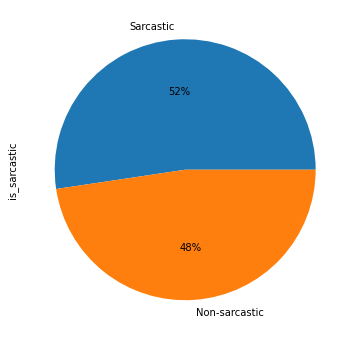

In [11]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [12]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [13]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: four black trailblazers on how they are empowering communities of color
label: 0

Headline: this 'jaws' analogy did not end well for mike huckabee
label: 0

Headline: u.s. loses u.n. membership after embarrassing video of nation surfaces on internet
label: 1

Headline: francis ford coppola says 'the godfather' wouldn't get made today
label: 0

Headline: bill cosby mug shot released
label: 0



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: nelson mandela evidently thinks world's journalists have nothing better to do than wait around like idiots
label: 1

Headline: jeff sessions argues family separations only happening because current law doesn't allow him to strangle immigrants with bare hands
label: 1

Headline: breitbart traffic down as readers now getting bulk of news analysis from graffiti scrawled across neighborhood
label: 1

Headline: michigan gop passes legislation rerouting flint drinking water to governor's mansion for incoming democrat
label: 1

Headline: marine biologists train highly intelligent octopus to profitably manage mid-size aluminum goods supplier
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
-----

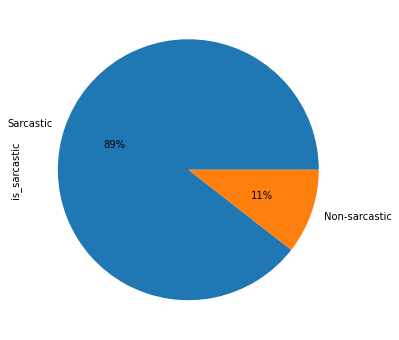

In [14]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

**Observation**
* 52% of the data have sarcastic labels whereas 48% don't.

* There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.

* Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.

* There are digits in the headlines
* 89% of data where length of sentence (headlines) > 100 are sarcastic headlines.

#### 2. Retain relevant columns

In [15]:
#Drop article_link from dataset.
data.drop('article_link', axis = 1, inplace = True)

**Data Preprocessing** - Few of the data pre-processing steps taken before applying model on the data

* Converting to lower case, avoid any capital cases
* Converting apostrophe to the standard lexicons
* Removing punctuations
* Lemmatization

In [16]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [17]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [18]:
import nltk
nltk.download('stopwords')

# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in data['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = False))
print('Data is cleaned!')

[nltk_data] Downloading package stopwords to C:\Users\Nikhila
[nltk_data]     KG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data is cleaned!


In [19]:
data['cleaned_headline'] = clean_balanced_headlines
data.head()

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word strea...


#### 3. Get length of each sentence

As different lines are of different length. We need to pad the our sequences using the max length.

In [20]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line'); 
print('Length of line ranges from 7 to 926.'); print('--'*40)
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print()
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].min()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the maximum length and print the maximum length line
Length of line ranges from 7 to 926.
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 926

Line with maximum length: bye bye


In [21]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
print('Number of words ranges from 2 to 167.'); print('--'*40)
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print()
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].min()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Number of words ranges from 2 to 167.
--------------------------------------------------------------------------------
Minimum number of words: 2
Maximum number of words: 167

Line with maximum number of words: sunday roundup


In [22]:
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])

#### Word cloud of Sarcastic Headlines

(-0.5, 399.5, 199.5, -0.5)

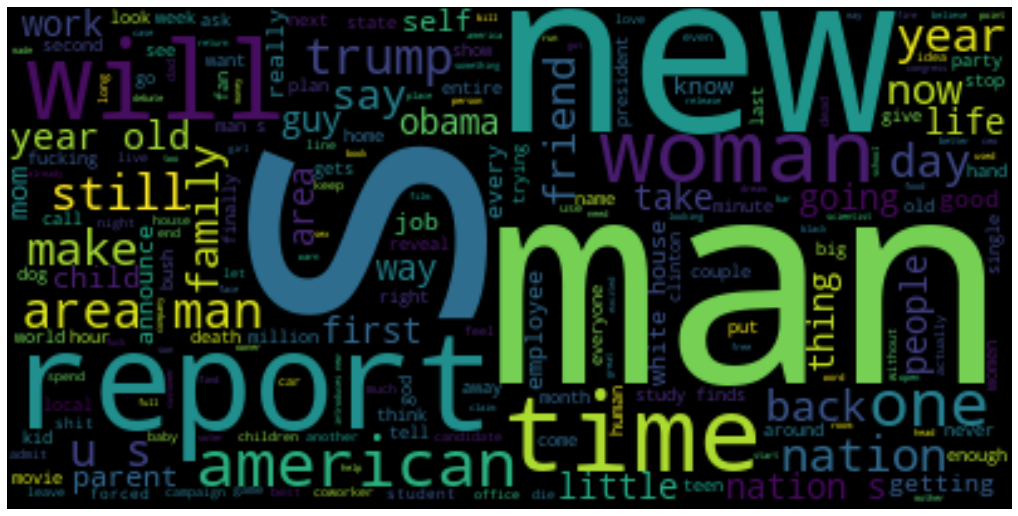

In [23]:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(sarcastic_headlines)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#### Word cloud of Non Sarcastic Headlines

(-0.5, 399.5, 199.5, -0.5)

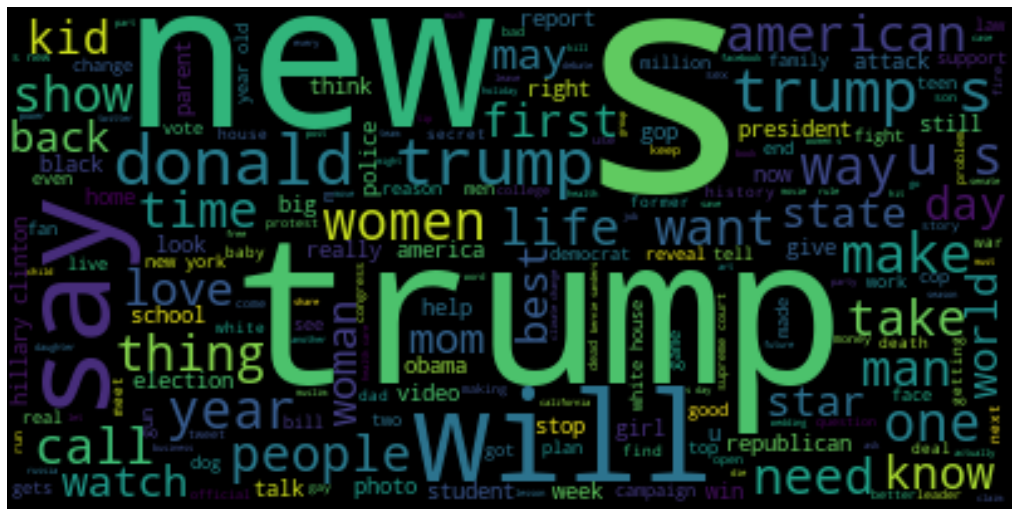

In [24]:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(non_sarcastic_headlines)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#### Modelling

In [25]:
print('--'*30); print('Five point summary for number of words')
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));print('--'*30)

------------------------------------------------------------
Five point summary for number of words


count    28619
mean        11
std          4
min          2
25%          9
50%         11
75%         14
max        167
Name: nb_words, dtype: int32

99% quantilie: 22.0
------------------------------------------------------------


#### 4. Define parameters

In [26]:
max_features = 10000
maxlen = data['nb_words'].max() #167
embedding_size = 200

#### 5. Get indices for words

In [27]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

#### 6. Create features and labels

In [28]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  359 3198 6352 2176    2  651 1142]

Label of the first headline: 1


#### 7. Get vocabulary size

In [29]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 26423


#### 8. Create a weight matrix using GloVe embeddings

#### Get Glove Word Embeddings

In [30]:
glove_file = 'D:/Nikhila/PGP - AIML/2. Projects/9. Natural Language Processing/Project 2/glove.6B.zip'

In [31]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

#### Get word embeddings using embedding file

In [32]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE,encoding="utf8"):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

#### Create a weight matrix

In [33]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

#### 9. Define and compile a Bidirectional LSTM model.

* Split the data into train, valid and test set so that it's easy to compare and evaluate
* Use Sequential model instance
* Add Embedding layer
* Bidirectional(LSTM) layer
* GlobalMaxPool1D layer
* Dense, dropout layers
* Add a final dense layer with sigmoid activation for binary classification

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 167
Number of unique words in training dataset: 9989
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 167
Number of unique words in test dataset: 7898


In [35]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 167, 200)          2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 167, 256)         336896    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

#### 10. Fit the model and check the validation accuracy

In [36]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 1: val_loss improved from inf to 0.44971, saving model to sarcasm_detector.h5
184/184 - 106s - loss: 0.5959 - accuracy: 0.6679 - val_loss: 0.4497 - val_accuracy: 0.8048 - lr: 0.0010 - 106s/epoch - 576ms/step
Epoch 2/6

Epoch 2: val_loss improved from 0.44971 to 0.38889, saving model to sarcasm_detector.h5
184/184 - 133s - loss: 0.4425 - accuracy: 0.8025 - val_loss: 0.3889 - val_accuracy: 0.8203 - lr: 0.0010 - 133s/epoch - 724ms/step
Epoch 3/6

Epoch 3: val_loss did not improve from 0.38889
184/184 - 138s - loss: 0.3777 - accuracy: 0.8378 - val_loss: 0.3908 - val_accuracy: 0.8281 - lr: 0.0010 - 138s/epoch - 748ms/step
Epoch 4/6

Epoch 4: val_loss improved from 0.38889 to 0.34308, saving model to sarcasm_detector.h5
184/184 - 135s - loss: 0.3319 - accuracy: 0.8596 - val_loss: 0.3431 - val_accuracy: 0.8528 - lr: 0.0010 - 135s/epoch - 736ms/step
Epoch 5/6

Epoch 5: val_loss improved from 0.34308 to 0.32539, saving model to sarcasm_detector.h5
184/184 - 151s - loss: 0.2949 

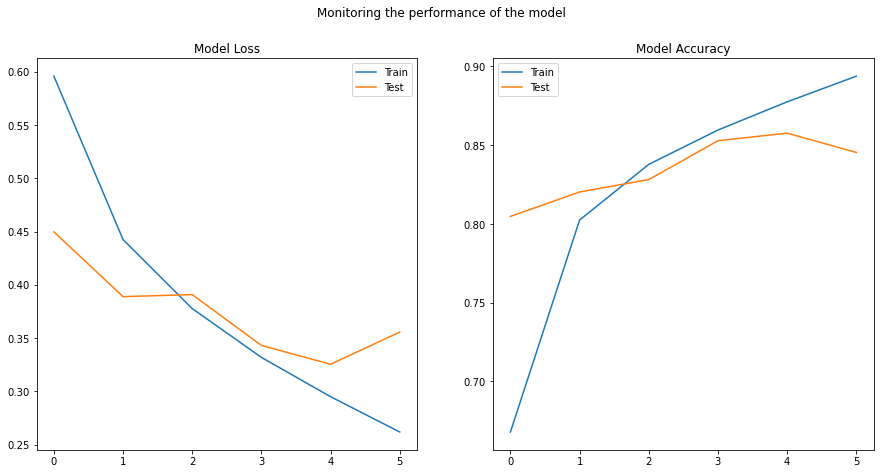

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 85.0


In [39]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

179/179 [==============================] - 13s 68ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      3438
           1       0.76      0.91      0.83      2286

    accuracy                           0.85      5724
   macro avg       0.84      0.86      0.85      5724
weighted avg       0.86      0.85      0.85      5724



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2781,214
Sarcastic,657,2072


------------------------------------------------------------


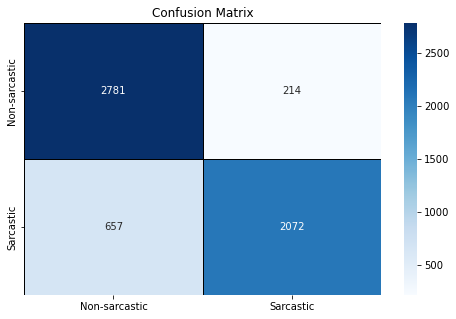

In [40]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

**Conclusion** - 
* Used Glove embedding layer with Bidirectional LSTM layer.Also saw how we can use tensorboard to visualize the metrics such as loss and accuracy.
* Created a separate training and test sets, while fitting the model kept aside a 0.2 for validation.
* Model achieved 85% accuracy on the test set; classification report and confusion matrix were also printed.

---------------------------